In [ ]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 25kB/s 
     |████████████████████████████████| 3.0MB 41.2MB/s 
     |████████████████████████████████| 460kB 40.5MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa.display
from pathlib import Path
from keras_preprocessing.image import ImageDataGenerator
import os

In [ ]:
data = pd.read_csv('/home/jena/Desktop/FYP/Data/csv/test.csv')
def images(audio):
    
    # We define the audiofile from the rows of the dataframe when we iterate through
    # every row of our dataframe for train, val and test
    audiofile = str(audio.filename)
    print(audio['filename'])
    
    # Loading the image with no sample rate to use the original sample rate and
    # kaiser_fast to make the speed faster according to a blog post about it (on references)
    X, sample_rate = librosa.load(audiofile, sr=None, res_type='kaiser_fast')
   
    # Setting the size of the image
    fig = plt.figure(figsize=[1,1])
    
    # This is to get rid of the axes and only get the picture 
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    
    # This is the melspectrogram from the decibels with a linear relationship
    S = librosa.feature.melspectrogram(y=X, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max),  y_axis='mel',x_axis='time')
    
    # Here we choose the path and the name to save the file, we will change the path when
    # using the function for train, val and test to make the function easy to use and output
    # the images in different folders to use later with a generator
    name = str(audio['filename'].split('/')[-2])+'_'+str(audio['filename'].split('/')[-1][:-4])
    id=audio['filename'].split('/')[-3]
    print(name)
    #name = name.split('.')[0]
    img  = 'images/' +str(id)+'/'+ str(name) + '.jpg'
    Path('images/' +str(id)+'/').mkdir(parents=True, exist_ok=True)
    # Here we finally save the image file choosing the resolution 
    plt.savefig(img, dpi=500, bbox_inches='tight',pad_inches=0)
    
    # Here we close the image because otherwise we get a warning saying that the image stays
    # open and consumes memory
    plt.close()

In [ ]:
data.head()

NameError: ignored

In [ ]:
data['speaker'].value_counts()>100

In [ ]:
ids = ["id11211","id11088","id11182","id11120"]
sample = pd.DataFrame([])
for i in ids:
    temp=data.query('speaker =="'+i+'"').head(100)
    #print(temp)
    sample = pd.concat([sample, temp], axis=0)
    #sample.append(temp,ignore_index = True)
    #print(sample)
sample

In [ ]:
for i in range((sample.shape[0]//100)+1):
    x=i*100
    sample[x:x+100].apply(images, axis=1)

In [4]:
loc=[]
se=[]
for path, subdirs, files in os.walk('/content/drive/My Drive/spectrogram/images/train_images'):
    for name in files:
        x=os.path.join(path, name)
        y=x.split('/')
        loc.append(y[-2]+'/'+y[-1])
        se.append(y[-2])
train_img_data=pd.DataFrame(list(zip(loc,se)),columns=['filename','speaker'])

In [7]:
ids=train_img_data['speaker'].unique()
ids

array(['id10434', 'id10168', 'id10045', 'id10929', 'id11211', 'id10020',
       'id11234', 'id10715', 'id10016', 'id10921', 'id10486', 'id10756',
       'id10107', 'id10104', 'id10449', 'id10525', 'id10343', 'id10856',
       'id11248', 'id10786', 'id10352', 'id10873', 'id10535', 'id11120',
       'id10148', 'id11022', 'id11157', 'id10376', 'id10371', 'id10321',
       'id10254', 'id10130', 'id10052', 'id10022', 'id10018'],
      dtype=object)

In [5]:
train = pd.DataFrame(columns=['filename','speaker'])
val = pd.DataFrame(columns=['filename','speaker'])
test = pd.DataFrame(columns=['filename','speaker'])
for index,row in test_img_data.iterrows():
    if index%10==0 or index%10==1 or index%10==3:
        val=val.append(row, ignore_index=True)
    else:
        train=train.append(row, ignore_index=True)

In [8]:
from keras_preprocessing.image import ImageDataGenerator

# Rescaling the images as usual to feed into the CNN
datagen=ImageDataGenerator(rescale=1./255.)

In [7]:
train_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/drive/My Drive/spectrogram/images/train_images",
    x_col="filename",
    y_col="speaker",
    batch_size=64,
    shuffle=True,
    class_mode='categorical',
    target_size=(128,128))

Found 5076 validated image filenames belonging to 35 classes.


In [8]:
val_generator=datagen.flow_from_dataframe(
    dataframe=val,
    directory="/content/drive/My Drive/spectrogram/images/train_images",
    x_col="filename",
    y_col="speaker",
    batch_size=64,
    shuffle=True,
    class_mode='categorical',
    target_size=(128,128))

Found 2177 validated image filenames belonging to 35 classes.


In [9]:
plt.close('all')

In [10]:
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers

# Building our model 
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(35, activation='softmax'))

In [11]:
# Compiling using adam and categorical crossentropy
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0

In [13]:
# Fitting our CNN with 250 epochs and setting the results to history for visuals
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=80,
                    validation_data=val_generator,
                    validation_steps=32,
                    epochs=200)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
80/80 [==============================] - 1453s 18s/step - loss: 3.5429 - accuracy: 0.0561 - val_loss: 3.5240 - val_accuracy: 0.0698
Epoch 2/200
80/80 [==============================] - 202s 3s/step - loss: 3.5086 - accuracy: 0.0695 - val_loss: 3.4860 - val_accuracy: 0.0718
Epoch 3/200
80/80 [==============================] - 193s 2s/step - loss: 3.4818 - accuracy: 0.0713 - val_loss: 3.4273 - val_accuracy: 0.0723
Epoch 4/200
80/80 [==============================] - 197s 2s/step - loss: 3.4407 - accuracy: 0.0776 - val_loss: 3.3681 - val_accuracy: 0.1157
Epoch 5/200
80/80 [==============================] - 194s 2s/step - loss: 3.2204 - accuracy: 0.1308 - val_loss: 2.9385 - val_accuracy: 0.1733
Epoch 6/200
80/80 [==============================] - 194s 2s/step - loss: 2.8089 - accuracy: 0.2017 - val_loss: 2.4508 - val_accuracy: 0.3223
Epoch 7/200
80/80 [==============================] - 196s 2s/step - lo

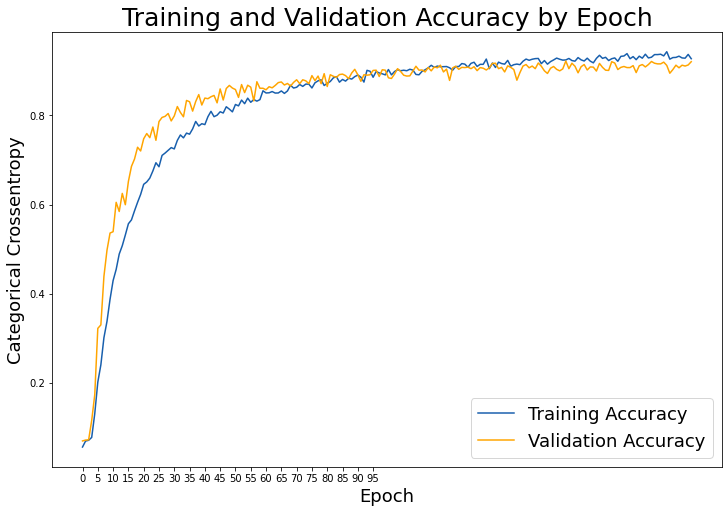

In [14]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.  
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))

plt.legend(fontsize = 18)
plt.show();

In [20]:
import pickle

# save the model to disk
#filename = '/content/drive/My Drive/spectrogram/finalized_model.sav'
#pickle.dump(model, open(filename, 'wb'))
model.save_weights("/content/drive/My Drive/spectrogram/model.h5")

In [21]:

# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/spectrogram/model.json", "w") as json_file:
    json_file.write(model_json)

In [13]:

model.load_weights("/content/drive/My Drive/spectrogram/model.h5")

In [14]:
loc=[]
se=[]
for path, subdirs, files in os.walk('/content/drive/My Drive/spectrogram/images/test_images'):
    for name in files:
        x=os.path.join(path, name)
        y=x.split('/')
        loc.append(y[-2]+'/'+y[-1])
        se.append(y[-2])
test_img_data=pd.DataFrame(list(zip(loc,se)),columns=['filename','speaker'])

In [17]:
test_img_data

,filename,speaker
0,id10434/SErC0C5Hoew_00006.jpg,id10434
1,id10434/euCFWBbLTAs_00011.jpg,id10434
2,id10434/ILBul7b3vEY_00007.jpg,id10434
3,id10434/euCFWBbLTAs_00038.jpg,id10434
4,id10434/UFqInE87wIs_00007.jpg,id10434
...,...,...
4566,id11027/M09F2ZYcGvE_00002.jpg,id11027
4567,id11027/1rDT7SwheMo_00022.jpg,id11027
4568,id11027/wq3QpQKy5Z0_00005.jpg,id11027
4569,id11027/TCbwEu15P1Q_00009.jpg,id11027


In [24]:
yz=list(ids)
test_img_data_35 = test_img_data[test_img_data['speaker'].isin(yz)]
test_img_data_35

,filename,speaker
0,id10434/SErC0C5Hoew_00006.jpg,id10434
1,id10434/euCFWBbLTAs_00011.jpg,id10434
2,id10434/ILBul7b3vEY_00007.jpg,id10434
3,id10434/euCFWBbLTAs_00038.jpg,id10434
4,id10434/UFqInE87wIs_00007.jpg,id10434
...,...,...
4351,id10018/sci80gk6bUc_00022.jpg,id10018
4352,id10018/sci80gk6bUc_00045.jpg,id10018
4353,id10018/eckQg181kQY_00018.jpg,id10018
4354,id10018/2fsToHH2Qz4_00006.jpg,id10018


In [25]:
test_generator=datagen.flow_from_dataframe(
    dataframe=test_img_data_35,
    directory="/content/drive/My Drive/spectrogram/images/test_images",
    x_col="filename",
    y_col="speaker",
    batch_size=64,
    shuffle=False,
    class_mode='categorical',
    target_size=(128,128))

Found 3249 validated image filenames belonging to 35 classes.


In [26]:
predict = model.predict_generator(test_generator,steps = 80)


Instructions for updating:
Please use Model.predict, which supports generators.


In [27]:
y_predict=np.argmax(predict,axis=1)

In [28]:
y_predict.shape

(3249,)

In [29]:
lables=(test_generator.class_indices)
lables=dict((v,k) for k,v in lables.items())

In [30]:
lables

{0: 'id10016',
 1: 'id10018',
 2: 'id10020',
 3: 'id10022',
 4: 'id10045',
 5: 'id10052',
 6: 'id10104',
 7: 'id10107',
 8: 'id10130',
 9: 'id10148',
 10: 'id10168',
 11: 'id10254',
 12: 'id10321',
 13: 'id10343',
 14: 'id10352',
 15: 'id10371',
 16: 'id10376',
 17: 'id10434',
 18: 'id10449',
 19: 'id10486',
 20: 'id10525',
 21: 'id10535',
 22: 'id10715',
 23: 'id10756',
 24: 'id10786',
 25: 'id10856',
 26: 'id10873',
 27: 'id10921',
 28: 'id10929',
 29: 'id11022',
 30: 'id11120',
 31: 'id11157',
 32: 'id11211',
 33: 'id11234',
 34: 'id11248'}

In [31]:
y_pred=[lables[k] for k in y_predict]

In [32]:
file_name=test_generator.classes
file_name
y_test = [lables[k] for k in file_name]
len(y_pred)

3249

In [34]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

print (confusion_matrix(y_test, y_pred))



[[ 68   0   0 ...   0   2   1]
 [  0  81   0 ...   1   0   0]
 [  0   0 192 ...   0   0   0]
 ...
 [  0   1   0 ... 147   0   0]
 [  0   0   1 ...   0  68   0]
 [  1   0   0 ...   0   0  62]]


In [36]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

     id10016       0.83      0.81      0.82        84
     id10018       0.89      0.91      0.90        89
     id10020       0.95      0.99      0.97       194
     id10022       1.00      0.97      0.99        69
     id10045       0.87      0.97      0.92        97
     id10052       0.94      0.90      0.92        67
     id10104       0.96      0.97      0.96        98
     id10107       0.94      0.98      0.96        96
     id10130       0.96      0.96      0.96        80
     id10148       0.93      0.96      0.94        93
     id10168       0.98      0.99      0.99       105
     id10254       0.97      0.95      0.96        87
     id10321       0.92      0.98      0.95        82
     id10343       0.95      0.98      0.97       126
     id10352       0.83      0.94      0.88       102
     id10371       0.86      0.89      0.88        71
     id10376       0.87      0.96      0.91        77
     id10434       0.96    